<a id='top'></a><a name='top'></a>
# Chapter 5: Feature Engineering and Syntactic Similarity

Book: [Blueprints for Text Analysis Using Python](https://www.oreilly.com/library/view/blueprints-for-text/9781492074076/)

Repo: https://github.com/blueprints-for-text-analytics-python/blueprints-text

* [Introduction](#introduction)
* [5.0 Imports and Setup](#5.0)
* [5.1 A Toy Dataset for Experimentation](#5.1)
* [5.2 Blueprint: Building Your Own Vectorizer](#5.2)
    - [5.2.1 Enumerating the Vocabulary](#5.2.1)
    - [5.2.2 Vectorizing Documents](#5.2.2)
    - [5.2.3 The Document-Term Matrix](#5.2.3)
    - [5.2.4 The Similarity Matrix](#5.2.4)
* [5.3 Bag-of-Words Models](#5.3)
    - [5.3.1 Blueprint: Using scikit-learn's CountVectorizer](#5.3.1)
    - [5.3.2 Blueprint: Calculating Similarities](#5.3.2)
* [5.4 TF-IDF Models](#5.4)
    - [5.4.1 Optimized Document Vectors with TfidfTransformer](#5.4.1)
    - [5.4.2 Introducing the ABC Datset](#5.4.2)
    - [5.4.3 Blueprint: Reducing Feature Dimensions](#5.4.3)
    - [5.4.4 Blueprint: Improving Features by Making Them More Specific](#5.4.4)
    - [5.4.5 Blueprint: Using Lemmas Instead of Words for Vectorizing Documents](#5.4.5)
    - [5.4.6 Blueprint: Limit Word Types](#5.4.6)
    - [5.4.7 Blueprint: Remove Most Common Words](#5.4.7)
    - [5.4.8 Blueprint: Adding Context via N-Grams](#5.4.8)
* [5.5 Syntactic Similarity in the ABC Dataset](#5.5)
    - [5.5.1 Blueprint: Finding Most Similar Headlines to a Made-up Headline](#5.5.1)
    - [5.5.2 Blueprint: Finding the Two Most Similar Documents in a Large Corpus (Much More Difficult)](#5.5.2)
    - [5.5.3 Blueprint: Finding Related Words)](#5.5.3)
    - [5.5.4 Tips for Long-Running Programs like Syntactic Similarity](#5.5.4)

---
<a name='introduction'></a><a id='introduction'></a>
# Introduction
<a href="#top">[back to top]</a>

### Dataset

* google-10000-english.txt: [script](#google-10000-english.txt), [source](https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt)
* ABC Australian news 2003-2017: [script](#abcnews-date-text.csv.gz), [source](https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/abcnews/abcnews-date-text.csv.gz)


### Explore

* How to convert documents to vectors using words or combinations as features. 
* The importance of similarity of documents and ways to calculate it.
* How to design and implement a custom vectorizer.
* The Bag-of-Words model and TF-IDF improvements to it.

---
<a name='5.0'></a><a id='5.0'></a>
# 5.0 Imports and Setup
<a href="#top">[back to top]</a>

In [1]:
# # Start with clean project
# !rm -f *.gz 
# !rm -f *.txt 
# !rm -f *.csv 
# !rm -f *.pkl 
# !rm -f *.py
# !ls -l

In [2]:
req_file = "requirements_05.txt"

In [1]:
%%writefile {req_file}
isort
tqdm
watermark

Writing {req_file}


In [2]:
import sys

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("Installing packages")
    !pip install --upgrade --quiet -r {req_file}
else:
    print("Running locally.")

Running locally.


In [3]:
%%writefile imports.py
import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark

Writing imports.py


In [4]:
!isort imports.py
!cat imports.py

import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark


In [5]:
import locale
import pprint
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from spacy.lang.en.stop_words import STOP_WORDS
from tqdm.auto import tqdm
from watermark import watermark

In [6]:
def HR():
    print("-"*40)
    
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
warnings.filterwarnings('ignore')
BASE_DIR = '.'
sns.set_style("darkgrid")
tqdm.pandas(desc="progress-bar")
pp = pprint.PrettyPrinter(indent=4)

print(watermark(iversions=True, globals_=globals(),python=True, machine=True))

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.18.1

Compiler    : Clang 14.0.0 (clang-1400.0.29.202)
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

numpy     : 1.26.0
spacy     : 3.7.4
matplotlib: 3.9.2
sys       : 3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]
seaborn   : 0.13.2
pandas    : 2.2.2



In [7]:
# Need to cast stopwords to a list so we can pass to TfidfVectorizer
stopwords = list(STOP_WORDS)

matrix_data = []

In [8]:
title_w = 10
val_w = 10
title_columns="Columns"
title_rows="Rows"
title_elements="Elements"
title_bytes="Bytes"
title_gb="Gigabytes"
    
df_names = [title_columns, title_elements, title_rows, "title"]
    
def examine_matrix(dt, title, add_to_df=True):

    print(f"{title_columns:<{title_w}} {dt.shape[0]:{val_w},}")
    print(f"{title_rows:<{title_w}} {dt.shape[1]:{val_w},}")
    print(f"{title_elements:<{title_w}} {dt.nnz:{val_w},}")
    print(f"{title_bytes:<{title_w}} {dt.data.nbytes:{val_w},}")
    print(f"{title_gb:<{title_w}} {round(dt.data.nbytes / (1024*1024*1024), 5):{val_w},}")

    matrix_row = {
        'title': title,
        title_columns: dt.shape[0],
        title_rows: dt.shape[1],
        title_elements: dt.nnz
    }
    if add_to_df:
        matrix_data.append(matrix_row)

In [9]:
def show(matrix_data):
    results = pd.DataFrame.from_records(matrix_data, index='title')
    row = results.iloc[:][['Columns','Rows','Elements']]
    row.plot(kind='barh', ylabel="", fontsize=8)
    
    plt.show()

---
<a name='5.1'></a><a id='5.1'></a>
# 5.1 A Toy Dataset for Experimentation
<a href="#top">[back to top]</a>

We use a few sentences from *A Tale of Two Cities* by Charles Dickens.

    It was the best of times.
    It was the worst of times.
    It was the age of wisdom.
    It was the age of foolishness.

---
<a name='5.2'></a><a id='5.2'></a>
# 5.2 Blueprint: Building Your Own Vectorizer
<a href="#top">[back to top]</a>

We implement a simple *one-hot vectorizer*. This creates binary vectors by representing the occurrence of a word in a document via 1 or 0.

<a name='5.2.1'></a><a id='5.2.1'></a>
## 5.2.1 Enumerating the Vocabulary
<a href="#top">[back to top]</a>

Convert words to the dimensions of the vectors. Extracting words from the text is done via tokenization.

In terms of representation, we are only interested in whether a word appears in a document or not.

In [10]:
sentences = ["It was the best of times", 
             "it was the worst of times", 
             "it was the age of wisdom", 
             "it was the age of foolishness"]

tokenized_sentences = [[t for t in sentence.split()] for sentence in sentences]
pp.pprint(tokenized_sentences)

[   ['It', 'was', 'the', 'best', 'of', 'times'],
    ['it', 'was', 'the', 'worst', 'of', 'times'],
    ['it', 'was', 'the', 'age', 'of', 'wisdom'],
    ['it', 'was', 'the', 'age', 'of', 'foolishness']]


In [11]:
vocabulary = set([w for s in tokenized_sentences for w in s])
pp.pprint(vocabulary)

{   'It',
    'age',
    'best',
    'foolishness',
    'it',
    'of',
    'the',
    'times',
    'was',
    'wisdom',
    'worst'}


In [12]:
pd.DataFrame([[w, i] for i,w in enumerate(vocabulary)])

,0,1
0,worst,0
1,wisdom,1
2,age,2
3,the,3
4,It,4
5,foolishness,5
6,of,6
7,times,7
8,it,8
9,best,9


<a name='5.2.2'></a><a id='5.2.2'></a>
## 5.2.2 Vectorizing Documents
<a href="#top">[back to top]</a>

To enable comparisons among vectors, we have to ensure the vectors for each document have the same number of dimensions.

To achieve this, we use the same dictionary for all documents. If the document doesn't contain a word, we represent that with a 0 at the corresponding position, otherwise we use a 1. By convention, row vectors are used for documents. The dimension of vectors is as big as the length of the dictionary. In large projects, the vocabulary can easily exceed 100,000 words. 

In [13]:
def onehot_encode(tokenized_sentence):
    return [1 if w in tokenized_sentence else 0 for w in vocabulary]

onehot = [onehot_encode(tokenized_sentence) for tokenized_sentence in tokenized_sentences]

for (sentence, oh) in zip(sentences, onehot):
    print("%s: %s" % (oh, sentence))

[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1]: It was the best of times
[1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]: it was the worst of times
[0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1]: it was the age of wisdom
[0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1]: it was the age of foolishness


In [14]:
sim = [onehot[0][i] & onehot[1][i] for i in range(0, len(vocabulary))]
sum(sim)

4

In [15]:
# Cannot use sets as columns anymore in Pandas, so we use a list.
vocabulary = list(vocabulary)
pd.DataFrame(onehot, columns=vocabulary)

,worst,wisdom,age,the,It,foolishness,of,times,it,best,was
0,0,0,0,1,1,0,1,1,0,1,1
1,1,0,0,1,0,0,1,1,1,0,1
2,0,1,1,1,0,0,1,0,1,0,1
3,0,0,1,1,0,1,1,0,1,0,1


### Out of vocabulary

In [16]:
onehot_encode("the age of wisdom is the best of times".split())

[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0]

If we try to vectorize a sentence with only unknown words, we get a null vector

In [17]:
onehot_encode("John likes to watch movies. Mary likes movies too.".split())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

<a name='5.2.3'></a><a id='5.2.3'></a>
## 5.2.3 The Document-Term Matrix
<a href="#top">[back to top]</a>

If we arrange the row vectors for each document in a matrix with the row enumerating the documents, we create a *document matrix*. This is a vector representation of all documents, and is a basic building block for many machine learning tasks. Here we will use it to calculate document similarities. 

With larger vocabularies, we can use spare vectors and matrices from SciPy.

In [18]:
pd.DataFrame(onehot, columns=vocabulary)

,worst,wisdom,age,the,It,foolishness,of,times,it,best,was
0,0,0,0,1,1,0,1,1,0,1,1
1,1,0,0,1,0,0,1,1,1,0,1
2,0,1,1,1,0,0,1,0,1,0,1
3,0,0,1,1,0,1,1,0,1,0,1


### Calculating similarities

Calculate the similarity of the first two sentences.

In [19]:
sim = [onehot[0][i] & onehot[1][i] for i in range(0, len(vocabulary))]
sum(sim)

4

We can also calculate the similarity by using the scalar product of the two document vectors. 

In [20]:
np.dot(onehot[0], onehot[1])

4

<a name='5.2.4'></a><a id='5.2.4'></a>
## 5.2.4 The Similarity Matrix
<a href="#top">[back to top]</a>

We can use a shortcut to calculate all numbers in a matrix, in order to find the similarity of all documents to each other. 

In [21]:
np.dot(onehot, np.transpose(onehot))

array([[6, 4, 3, 3],
       [4, 6, 4, 4],
       [3, 4, 6, 5],
       [3, 4, 5, 6]])

### One-Hot Encoding with scikit-learn

We can also do vectorization with scikit-learn. For this, we do not use `OneHotEncoder`, since it suitable only for categorical features. Instead, we use `MultiLabelBinarizer`.


In [22]:
lb = MultiLabelBinarizer()
lb.fit([vocabulary])
lb.transform(tokenized_sentences)

array([[1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1],
       [0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0]])

---
<a name='5.3'></a><a id='5.3'></a>
# 5.3 Bag-of-Words Models
<a href="#top">[back to top]</a>

One-hot encoding is a basic representation of documents as vectors, however it does not represent the number of times words appear. In order to represent word frequency, we can use a *bag-of-words* representation. 

Although somewhat simplistic, these models are in wide use. For cases such as classification and sentiment detection, they work reasonably. Moreover, there are topic modeling methods like Latent Dirichlet Allocation (LDA), which explicitly requires a bag-of-words model.

<a name='5.3.1'></a><a id='5.3.1'></a>
## 5.3.1 Blueprint: Using scikit-learn's CountVectorizer
<a href="#top">[back to top]</a>

We use scikit-learn's `CountVectorizer` algorithm to create a bag-of-words model.

`CountVectorizer` works in two steps:

1. Learn the vocabulary
2. Transform the documents to vectors.

In [23]:
cv = CountVectorizer()

# Default parameters
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': None,
 'min_df': 1,
 'ngram_range': (1, 1),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

Add additional sentences to our dataset. 

In [24]:
more_sentences = sentences + ["John likes to watch movies. Mary likes movies too.",
                              "Mary also likes to watch football games."]
pd.DataFrame(more_sentences)

,0
0,It was the best of times
1,it was the worst of times
2,it was the age of wisdom
3,it was the age of foolishness
4,John likes to watch movies. Mary likes movies ...
5,Mary also likes to watch football games.


### Learning and fitting the vocabulary

In [25]:
cv.fit(more_sentences)

CountVectorizer()

Examine what CountVectorizer uses as vocabulary, which is called *feature names*.

In [26]:
pp.pprint(cv.get_feature_names_out())

array(['age', 'also', 'best', 'foolishness', 'football', 'games', 'it',
       'john', 'likes', 'mary', 'movies', 'of', 'the', 'times', 'to',
       'too', 'was', 'watch', 'wisdom', 'worst'], dtype=object)


### Transforming the vocabulary to vectors

In this second step, we use `CountVectorizer` to transform the documents to the vector representation. 

In [27]:
dt = cv.transform(more_sentences)

examine_matrix(dt, 'simple', add_to_df=False)

Columns             6
Rows               20
Elements           38
Bytes             304
Gigabytes         0.0


We created a document-term matrix, however it is a different object, a sparse matrix.

Recover our original document-matrix. by transforming the sparse matrix to a dense array. 

In [28]:
# Easier to read as a Pandas Dataframe
pd.DataFrame(dt.toarray(), columns=cv.get_feature_names_out())

,age,also,best,foolishness,football,games,it,john,likes,mary,movies,of,the,times,to,too,was,watch,wisdom,worst
0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1,1,1,0,0,1,0,0,1
2,1,0,0,0,0,0,1,0,0,0,0,1,1,0,0,0,1,0,1,0
3,1,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,1,2,1,2,0,0,0,1,1,0,1,0,0
5,0,1,0,0,1,1,0,0,1,1,0,0,0,0,1,0,0,1,0,0


<a name='5.3.2'></a><a id='5.3.2'></a>
## 5.3.2 Blueprint: Calculating Similarities
<a href="#top">[back to top]</a>

Finding similarities between documents is now more difficult since we cannot just count the common 1s in the document. We also cannot use the dot product, since it is sensitive to the length of the vector. 

Instead, we use the cosine of the angle between two vectors.  scikit-learn provides the `cosine_similarity` utility function for this. This function is properly normalized and only takes values between 0 and 1.

In [29]:
cosine_similarity(dt[0], dt[1])

array([[0.83333333]])

We can also calculate the similarity of all documents with `cosine_similarity`, by directly passing the matrices.

In [30]:
pd.DataFrame(cosine_similarity(dt, dt))

,0,1,2,3,4,5
0,1.000000,0.833333,0.666667,0.666667,0.000000,0.000000
1,0.833333,1.000000,0.666667,0.666667,0.000000,0.000000
2,0.666667,0.666667,1.000000,0.833333,0.000000,0.000000
3,0.666667,0.666667,0.833333,1.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,1.000000,0.524142
5,0.000000,0.000000,0.000000,0.000000,0.524142,1.000000


In [31]:
len(more_sentences)

6

---
<a name='5.4'></a><a id='5.4'></a>
# 5.4 TF-IDF Models
<a href="#top">[back to top]</a>

TF-IDF stands for "Term Frequency - Inverse Document Frequency".

TF-IDF counts the number of total word occurrences. It will reduce weights of frequent words and at the same time increase the weights of uncommon words.

Conceptually this is related to the concept of entropy, which says that a low-probability value carries more information than a more likely value.

<a name='5.4.1'></a><a id='5.4.1'></a>
## 5.4.1 Optimized Document Vectors with TfidfTransformer
<a href="#top">[back to top]</a>

A better measure for information (compared to simply counting terms) is calculating the inverted document frequency and using a penalty for very common words. The TF-IDF weight can be calculated from the bag-of-words model. We can use this on the previous model and see how the weights of the document-term matrix change. 

`TfidfTransformer` transforms a count matrix to a normalized tf or tf-idf representation.

In [32]:
tfidf = TfidfTransformer()
tfidf_dt = tfidf.fit_transform(dt)

examine_matrix(dt, 'TfidfTransformer', add_to_df=False)

Columns             6
Rows               20
Elements           38
Bytes             304
Gigabytes         0.0


In [33]:
pd.DataFrame(tfidf_dt.toarray(), columns=cv.get_feature_names_out())

,age,also,best,foolishness,football,games,it,john,likes,mary,movies,of,the,times,to,too,was,watch,wisdom,worst
0,0.000000,0.000000,0.56978,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.467228,0.000000,0.000000,0.338027,0.000000,0.00000,0.00000
1,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.467228,0.000000,0.000000,0.338027,0.000000,0.00000,0.56978
2,0.467228,0.000000,0.00000,0.00000,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.000000,0.000000,0.000000,0.338027,0.000000,0.56978,0.00000
3,0.467228,0.000000,0.00000,0.56978,0.000000,0.000000,0.338027,0.000000,0.000000,0.000000,0.000000,0.338027,0.338027,0.000000,0.000000,0.000000,0.338027,0.000000,0.00000,0.00000
4,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.305609,0.501208,0.250604,0.611219,0.000000,0.000000,0.000000,0.250604,0.305609,0.000000,0.250604,0.00000,0.00000
5,0.000000,0.419233,0.00000,0.00000,0.419233,0.419233,0.000000,0.000000,0.343777,0.343777,0.000000,0.000000,0.000000,0.000000,0.343777,0.000000,0.000000,0.343777,0.00000,0.00000


In [34]:
pd.DataFrame(cosine_similarity(tfidf_dt, tfidf_dt))

,0,1,2,3,4,5
0,1.000000,0.675351,0.457049,0.457049,0.00000,0.00000
1,0.675351,1.000000,0.457049,0.457049,0.00000,0.00000
2,0.457049,0.457049,1.000000,0.675351,0.00000,0.00000
3,0.457049,0.457049,0.675351,1.000000,0.00000,0.00000
4,0.000000,0.000000,0.000000,0.000000,1.00000,0.43076
5,0.000000,0.000000,0.000000,0.000000,0.43076,1.00000


<a name='5.4.2'></a><a id='5.4.2'></a>
## 5.4.2 Introducing the ABC Dataset
<a href="#top">[back to top]</a>

We use a dataset from Kaggle containing news headlines, originating from [ABC Australian news 2003-2017](`CountVectorizer`).

<a id='abcnews-date-text.csv.gz'></a><a name='abcnews-date-text.csv.gz'></a>
### Dataset: abcnews-date-text.csv.gz
<a href="#top">[back to top]</a>

In [35]:
ABCNEWS_FILE = 'abcnews-date-text.csv.gz'
!wget -nc -q https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/abcnews/abcnews-date-text.csv.gz
!ls -l {ABCNEWS_FILE}

-rw-r--r--  1 gpb  staff  19282568 11  2 16:25 abcnews-date-text.csv.gz


In [36]:
headlines_orig = pd.read_csv(ABCNEWS_FILE, parse_dates=["publish_date"])
headlines_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1103663 entries, 0 to 1103662
Data columns (total 2 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   publish_date   1103663 non-null  datetime64[ns]
 1   headline_text  1103663 non-null  object        
dtypes: datetime64[ns](1), object(1)
memory usage: 16.8+ MB


### Shorten size of headline, as it takes too long to process the original length

In [37]:
# Shorten dataset
# headlines = headlines_orig.sample(frac=.1)
headlines = headlines_orig.sample(n=20_000)
print(f"{len(headlines):,}")

20,000


In [38]:
headlines.sample(5)

,publish_date,headline_text
105742,2004-07-28,portrait planned for thunderbolts rock
771498,2013-03-18,call for boundary changes before council de me...
1097330,2017-11-03,cb radios facebook of the 70s back in fashion
434538,2009-01-04,police probe acacia ridge armed robbery
773204,2013-03-22,un to probe possible syrian chemical weapons a...


In [39]:
tfidf = TfidfVectorizer()
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.2 TfidfVectorizer')

Columns        20,000
Rows           17,882
Elements      126,698
Bytes       1,013,584
Gigabytes     0.00094


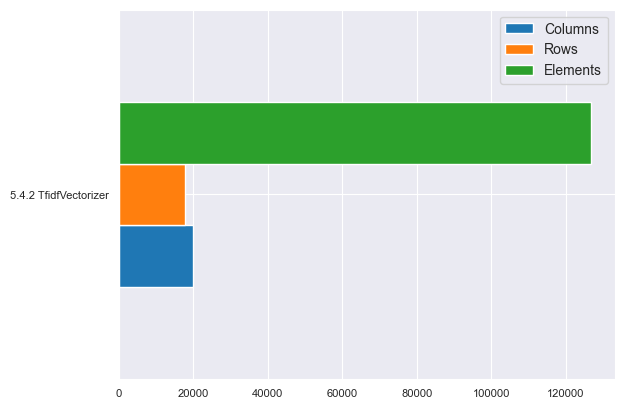

In [40]:
show(matrix_data)

Calculate the similarity between two vectors is very efficient via `cosine_similarity`.

In [41]:
%%time
# Use Pandas for better UI.
pd.DataFrame(cosine_similarity(dt[0:10000], dt[0:10000]))

CPU times: user 354 ms, sys: 289 ms, total: 643 ms
Wall time: 652 ms


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
1,0.0,1.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
2,0.0,0.0,1.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
3,0.0,0.0,0.0,1.000000,0.000000,0.0,0.0,0.103828,0.0,0.0,...,0.000000,0.054342,0.000000,0.000000,0.000000,0.047807,0.000000,0.0,0.283263,0.0
4,0.0,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.030047,0.220906,0.029186,0.000000,0.000000,0.0,0.026567,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.047807,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.045452,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.034937,0.0
9996,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.049715,0.0,0.0,...,0.000000,0.000000,0.113251,0.000000,0.061827,0.000000,1.000000,0.0,0.056279,0.0
9997,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.083174,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0
9998,0.0,0.0,0.0,0.283263,0.026567,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.039713,0.080288,0.000000,0.077987,0.034937,0.056279,0.0,1.000000,0.0


<a name='5.4.3'></a><a id='5.4.3'></a>
## 5.4.3 Blueprint: Reducing Feature Dimensions
<a href="#top">[back to top]</a>

We can optimize vectorization by removing unnecesary features when calculating similarities. 

### Removing Stopwords

This does not reduce the number of dimensions much, but it should drastically decrease the number of stored elements. 

In [42]:
print(len(stopwords))

326


In [43]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords')

Columns        20,000
Rows           17,656
Elements      102,004
Bytes         816,032
Gigabytes     0.00076


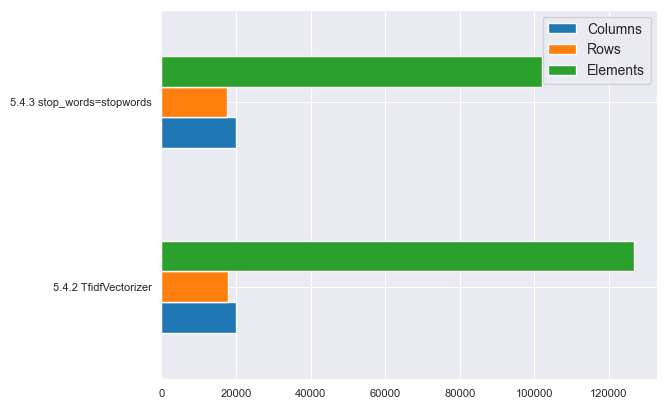

In [44]:
show(matrix_data)

### Minimum frequency

Components can contribute only if both vectors have a nonzero value at the corresponding index. Hence, we can neglect all words occurring less than twice. 

`TfidfVectorizer` has a parameter called `min_df` for this.

In [45]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, min_df=2')

Columns        20,000
Rows            8,953
Elements       93,301
Bytes         746,408
Gigabytes      0.0007


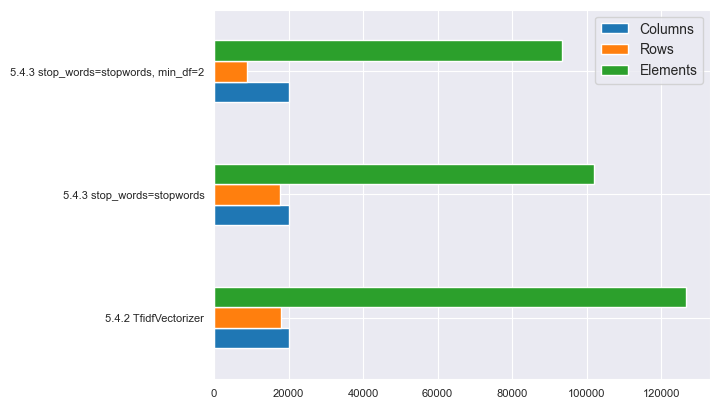

In [46]:
show(matrix_data)

### Using min_df as a fraction

In [47]:
tfidf = TfidfVectorizer(stop_words=stopwords, min_df=.0001)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, min_df=.0001')

Columns        20,000
Rows            8,953
Elements       93,301
Bytes         746,408
Gigabytes      0.0007


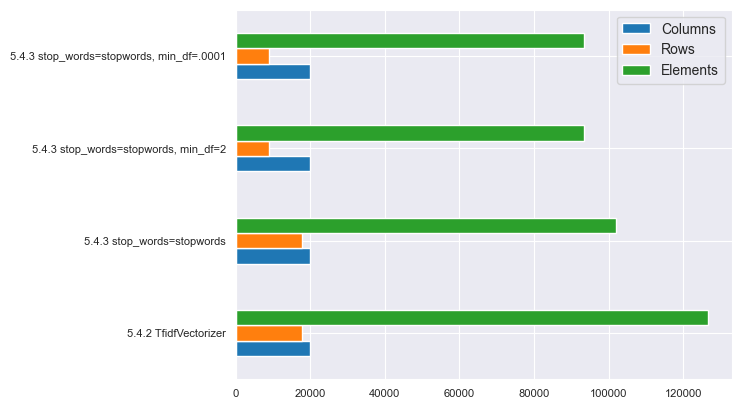

In [48]:
show(matrix_data)

### Maximum frequency

We can use the `max_df` parameter to eliminate terms occurring too often in the corpus. Here we eliminate all words that appear in at least 10% of the headlines. 

We can see that a setting of 10% does not eliminate any words, implying our news headlines are very diverse.

In [49]:
tfidf = TfidfVectorizer(stop_words=stopwords, max_df=0.1)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, max_df=0.1')

Columns        20,000
Rows           17,656
Elements      102,004
Bytes         816,032
Gigabytes     0.00076


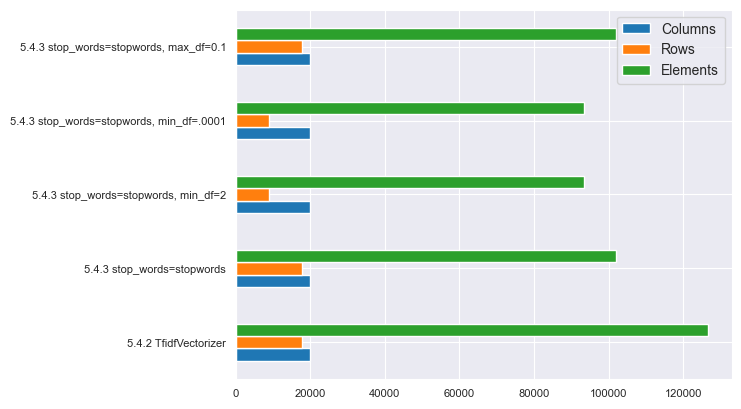

In [50]:
show(matrix_data)

### n-grams

In [51]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, ngram_range=(1,2), min_df=2')

Columns        20,000
Rows           14,186
Elements      109,548
Bytes         876,384
Gigabytes     0.00082


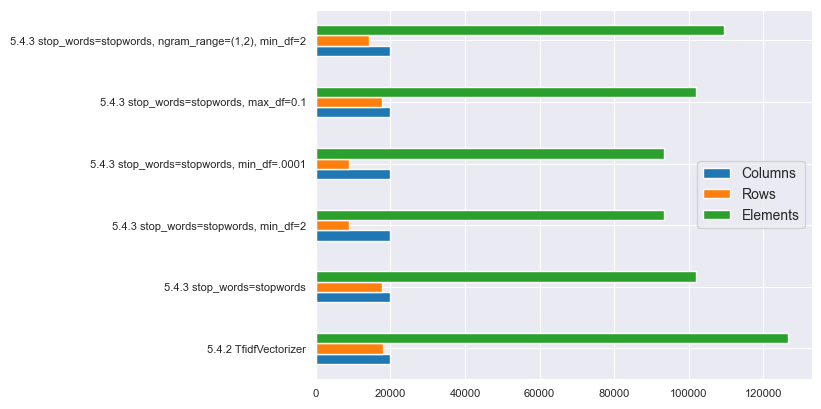

In [52]:
show(matrix_data)

In [53]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=2)
dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.4.3 stop_words=stopwords, ngram_range=(1,3), min_df=2')

Columns        20,000
Rows           14,773
Elements      111,072
Bytes         888,576
Gigabytes     0.00083


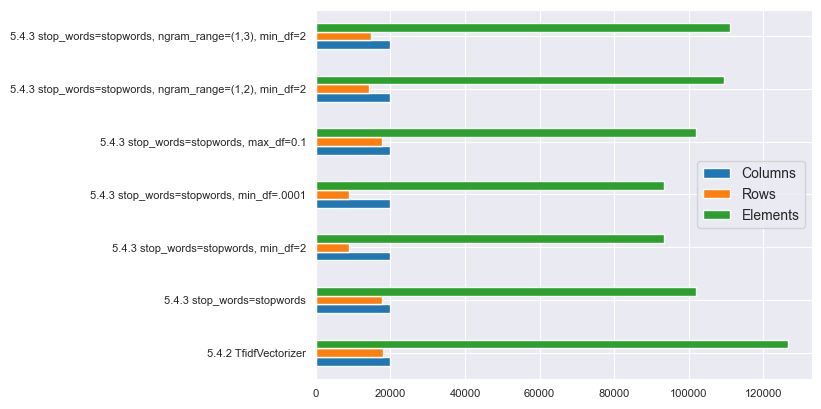

In [54]:
show(matrix_data)

<a name='5.4.4'></a><a id='5.4.4'></a>
## 5.4.4 Blueprint: Improving Features by Making Them More Specific
<a href="#top">[back to top]</a>

Up to now, we have used the original headline words, and reduced the number of dimensions by stop words and counting frequencies. 

However, we have not changed the features themselves. Next, we can use linguistic analysis for more possibilities. 

### Lemmas

Using spaCy, we can lemmatize all headlines and keep only the lemmas. This results in a smaller vocabulary. 

First, we have to perform a linguistic analysis. 

---
Pandas Note: `headlines.at`

Access a single value for a row/column label pair.

Similar to `loc`, in that both provide label-based lookups. 

Use `at` if you only need to get or set a single value in a DataFrame
or Series.


    .loc can take multiple rows and columns as input arguments
    .at can only take one row and one column as input arguments

    DataFrame.at: Access a single value for a row/column pair by label.
    DataFrame.iat: Access a single value for a row/column pair by integer position.
    DataFrame.loc: Access a group of rows and columns by label(s).
    DataFrame.iloc: Access a group of rows and columns by integer position(s).

In [55]:
%%time
# This takes a long time to run!

nlp = spacy.load("en_core_web_sm")

nouns_adjectives_verbs = ["NOUN", "PROPN", "ADJ", "ADV", "VERB"]

for i, row in tqdm(headlines.iterrows(), total=len(headlines)):
    doc = nlp(str(row["headline_text"]))
    headlines.at[i, "lemmas"] = " ".join([token.lemma_ for token in doc])
    headlines.at[i, "nav"] = " ".join([token.lemma_ for token in doc if token.pos_ in nouns_adjectives_verbs])

  0%|          | 0/20000 [00:00<?, ?it/s]

CPU times: user 3min, sys: 4.68 s, total: 3min 4s
Wall time: 3min 29s


In [56]:
# Compare
headlines[["lemmas", "headline_text", "nav"]].head()

,lemmas,headline_text,nav
417419,rabbit invade mandela museum island,rabbits invade mandela museum island,rabbit invade mandela museum island
595984,ambrose daytona dream bring to halt,ambroses daytona dream brought to halt,ambrose daytona dream bring halt
280113,port augusta violence,port augusta violence,port augusta violence
4743,policeman find not guilty of rape,policeman found not guilty of rape,policeman find guilty rape
563506,no collusion in militant prison murder,no collusion in militants prison murder,collusion militant prison murder


In [57]:
headlines.to_csv('headlines_lemma.csv')
headlines.to_pickle("headlines_lemma.pkl")
!ls -l *.csv
!ls -l *.pkl

-rw-r--r--  1 gpb  staff  2664322 11  2 16:28 headlines_lemma.csv
-rw-r--r--  1 gpb  staff  2743798 11  2 16:28 headlines_lemma.pkl


<a name='5.4.5'></a><a id='5.4.5'></a>
## 5.4.5 Blueprint: Using Lemmas Instead of Words for Vectorizing Documents
<a href="#top">[back to top]</a>

After the previous linguistic analysis, we can vectorize the data using the lemmas, and see how the vocabulary decreased. 

In [58]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["lemmas"].map(str))

examine_matrix(dt, '5.4.5 stop_words=stopwords, headlines["lemmas"]')

Columns        20,000
Rows           14,427
Elements      100,294
Bytes         802,352
Gigabytes     0.00075


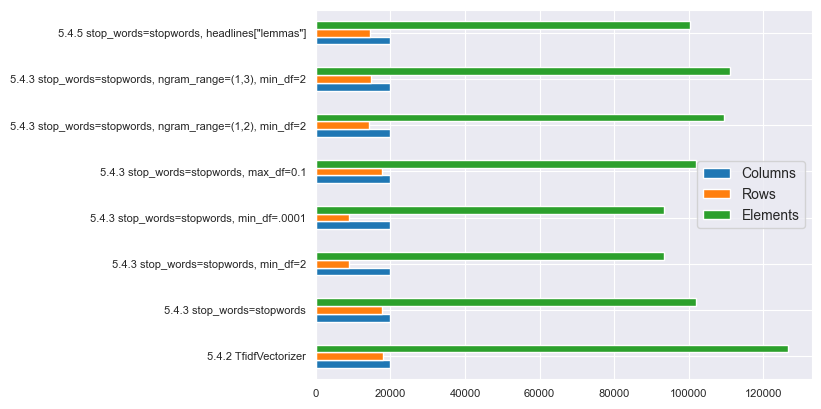

In [59]:
show(matrix_data)

<a name='5.4.6'></a><a id='5.4.6'></a>
## 5.4.6 Blueprint: Limit Word Types
<a href="#top">[back to top]</a>

With our data now, we can restrict operations to just nouns, adjectives and verbs for vectorization. This assumes prepositions, conjugations, etc carry little meaning. 

In [60]:
tfidf = TfidfVectorizer(stop_words=stopwords)
dt = tfidf.fit_transform(headlines["nav"].map(str))

examine_matrix(dt, '5.4.6 stop_words=stopwords, headlines["nav"]')

Columns        20,000
Rows           14,030
Elements       98,402
Bytes         787,216
Gigabytes     0.00073


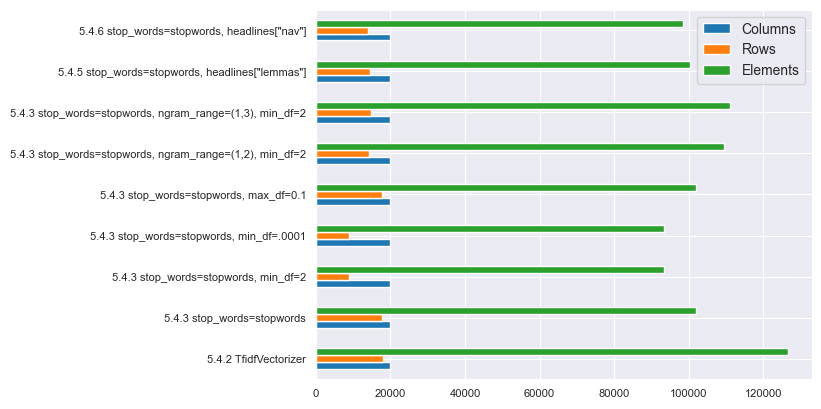

In [61]:
show(matrix_data)

<a name='5.4.7'></a><a id='5.4.7'></a>
## 5.4.7 Blueprint: Remove Most Common Words
<a href="#top">[back to top]</a>

We can try removing the most common English words via a list from Google. 

### remove top 10,000

<a id='google-10000-english.txt'></a><a name='google-10000-english.txt'></a>
### Dataset: google-10000-english.txt
<a href="#top">[back to top]</a>

In [62]:
google_10k_file = 'google-10000-english.txt'
!wget -nc -q https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt
!ls -l {google_10k_file}

-rw-r--r--  1 gpb  staff  75888 11  2 16:28 google-10000-english.txt


In [63]:
top_10000 = pd.read_csv(google_10k_file, header=None)

top_10000.describe()

,0
count,9999
unique,9999
top,the
freq,1


In [64]:
top_10000.sample(3)

,0
5565,arrangement
4245,blind
8822,yeast


In [65]:
tfidf = TfidfVectorizer(
    stop_words=list(set(top_10000.iloc[:,0].values))
)
dt = tfidf.fit_transform(headlines["nav"].map(str))

examine_matrix(dt, '5.4.7 remove top 10K, headlines["nav"]')

Columns        20,000
Rows            9,359
Elements       24,447
Bytes         195,576
Gigabytes     0.00018


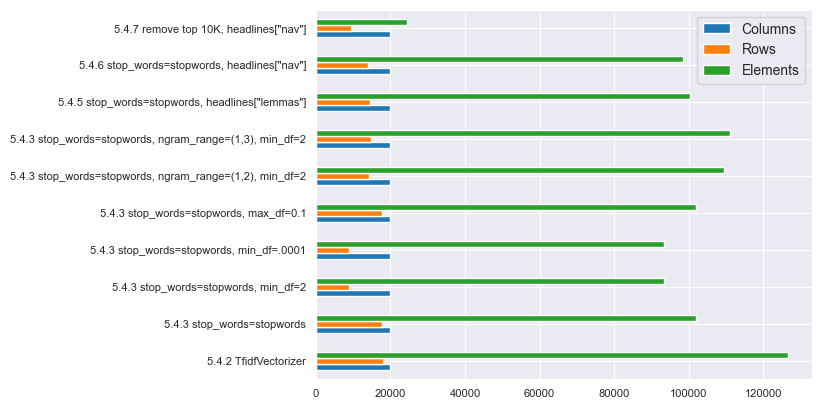

In [66]:
show(matrix_data)

<a name='5.4.8'></a><a id='5.4.8'></a>
## 5.4.8 Blueprint: Adding Context via N-Grams
<a href="#top">[back to top]</a>

Up to now, we have only used single words as features as the basis for our vectorization. In this strategy, we have lost a lot of context information.

Here, we use a simple method to represent word combinations, called *n-grams*. 

### bigrams

In [67]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2), min_df=2) 
dt = tfidf.fit_transform(headlines["headline_text"])
print("Bigrams")

examine_matrix(dt, '5.4.8 stop_words=stopwords, ngram_range=(1,2), min_df=2')

Bigrams
Columns        20,000
Rows           14,186
Elements      109,548
Bytes         876,384
Gigabytes     0.00082


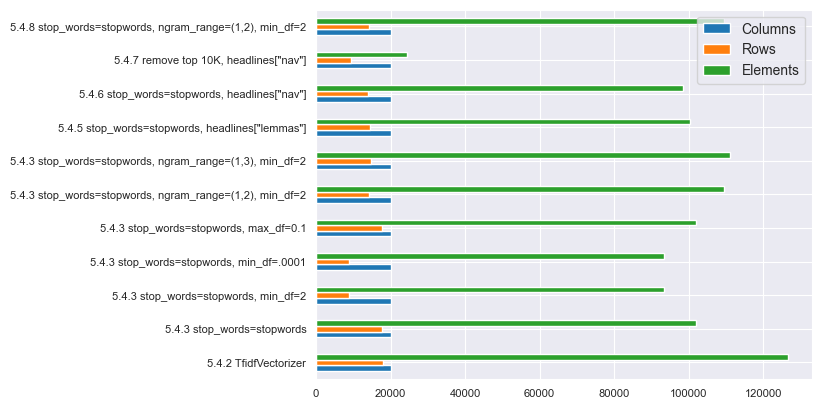

In [68]:
show(matrix_data)

### trigrams

In [69]:
tfidf = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,3), min_df=2) 
dt = tfidf.fit_transform(headlines["headline_text"])
print("Trigrams")

examine_matrix(dt, '5.4.8 stop_words=stopwords, ngram_range=(1,3), min_df=2')

Trigrams
Columns        20,000
Rows           14,773
Elements      111,072
Bytes         888,576
Gigabytes     0.00083


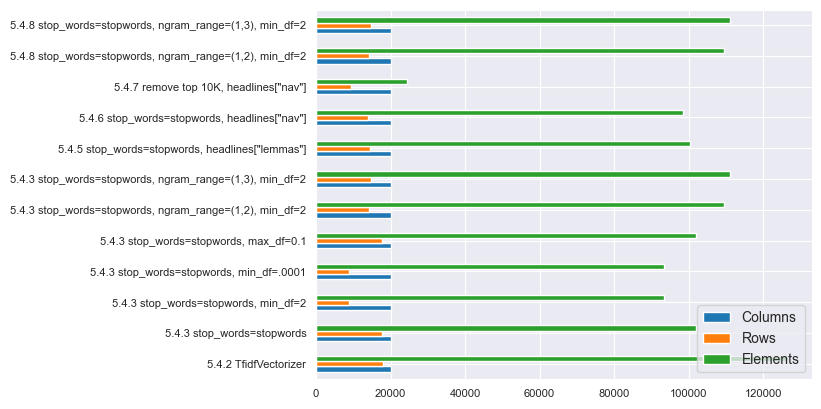

In [70]:
show(matrix_data)

### bigrams with linguistic features (nav)

Combining n-grams with linguistic features and common words is also possible and reduces the vocabulary size considerably.

In [71]:
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    stop_words=list(set(top_10000.iloc[:,0].values))
)
dt = tfidf.fit_transform(headlines["nav"].map(str))

print("Bigrams and Stopwords")

examine_matrix(dt, '5.4.8 ngram_range=(1,2), headlines["nav"]')

Bigrams and Stopwords
Columns        20,000
Rows           18,488
Elements       33,889
Bytes         271,112
Gigabytes     0.00025


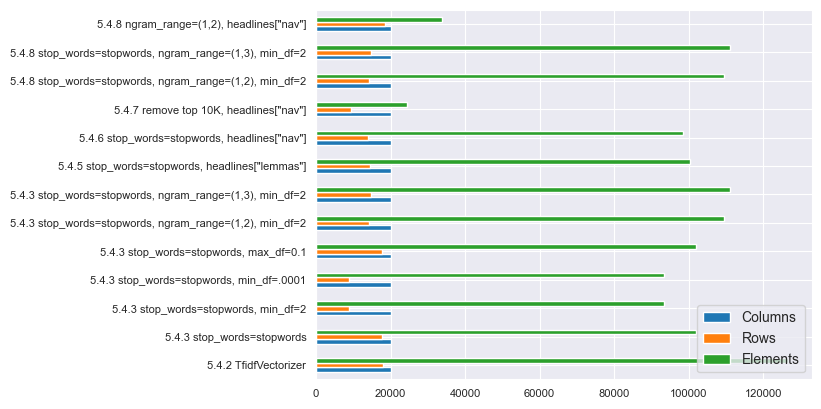

In [72]:
show(matrix_data)

<a name='5.5'></a><a id='5.5'></a>
# 5.5 Syntactic Similarity in the ABC Dataset
<a href="#top">[back to top]</a>

*Similarity* is one of the most basic concepts in machine learning and text analytics. Here we explore the more difficult problems finding similar documents in the ABC dataset. 

First, vectorize the dataset using stop words and bigrams. 

In [73]:
stopwords.append("test")

tfidf = TfidfVectorizer(
    stop_words=stopwords, 
    min_df=2,
    ngram_range=(1,2),
    norm='l2'
)

dt = tfidf.fit_transform(headlines["headline_text"].map(str))

examine_matrix(dt, '5.5 headline_text, norm=l2')

Columns        20,000
Rows           14,170
Elements      109,428
Bytes         875,424
Gigabytes     0.00082


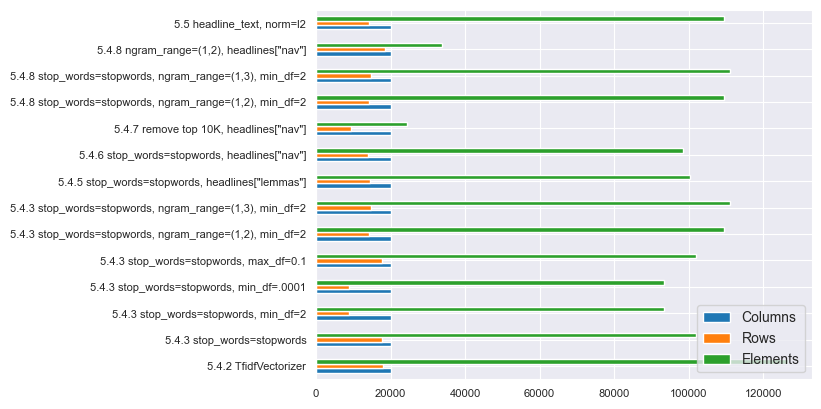

In [74]:
show(matrix_data)

<a name='5.5.1'></a><a id='5.5.1'></a>
## 5.5.1 Blueprint: Finding Most Similar Headlines to a Made-up Headline
<a href="#top">[back to top]</a>

To search for a headline, we just have to vectorize our new document-query. 

In [75]:
query = "australia and new zealand discuss optimal apple size"
print(query)
HR()

made_up = tfidf.transform([query])
made_up

australia and new zealand discuss optimal apple size
----------------------------------------


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 14170)>

In [76]:
made_up.__dict__

{'_shape': (1, 14170),
 'maxprint': 50,
 'indices': array([14159, 11659,  8647,  8568,  3735,  1002,   746], dtype=int32),
 'indptr': array([0, 7], dtype=int32),
 'data': array([0.39721463, 0.46974746, 0.39721463, 0.23423646, 0.38642005,
        0.27345924, 0.42989681])}

In [77]:
for x in made_up:
    print(x)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 14170)>
  Coords	Values
  (0, 14159)	0.3972146311181544
  (0, 11659)	0.4697474564275784
  (0, 8647)	0.3972146311181544
  (0, 8568)	0.23423645990495875
  (0, 3735)	0.386420052377635
  (0, 1002)	0.2734592363465938
  (0, 746)	0.42989681420028414


We need to calculate the cosine similarity to each headline in the corpus. We can use `cosine_similarity` for this.

In [78]:
sim = cosine_similarity(made_up, dt)

The result is a number of headlines in the corpus x 1 matrix, where each number represents the similarity to a document in the corpus. Using `np.argmax` gives us the index of the most similar document.

In [79]:
sim[0]

array([0.        , 0.        , 0.        , ..., 0.        , 0.04569349,
       0.        ])

In [80]:
# Get the top-5
headlines.iloc[np.argsort(sim[0])[::-1][0:5]][["publish_date", "lemmas"]]

,publish_date,lemmas
331688,2007-09-18,new zealand police spokeswoman noreen higgerty
959078,2015-06-10,new zealand young farmer
780034,2013-04-18,kangaroo take on new zealand in anzac test
546062,2010-06-23,new zealand maori topple england
958952,2015-06-10,competitive new zealand wine industry


<a name='5.5.2'></a><a id='5.5.2'></a>
## 5.5.2 Blueprint: Finding the Two Most Similar Documents in a Large Corpus (Much More Difficult)
<a href="#top">[back to top]</a>

We want to search for duplicates in this corpus. We cannot simply calculate the `cosine_similarity` between all documents anymore, because of the larger size of the dataset. 

Instead, we use other optimizations. One method is to calculate only the subdiagonal elements of the similarity matrix. 

We can then divide the problem into different blocks and calculate similarity submatrices. 

NOTE ON TfidfVectorizer API:

* norm: {‘l1’, ‘l2’} or None, default=’l2’

    Each output row will have unit norm, either:

    - ‘l2’: Sum of squares of vector elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.
    - ‘l1’: Sum of absolute values of vector elements is 1. See preprocessing.normalize.
    - None: No normalization.


    

In [81]:
# There are "test" headlines in the corpus
stopwords.append("test")

# Achieve speed up via normalizing the TF-IDF vectors with norm='l2'
tfidf = TfidfVectorizer(
    stop_words=stopwords, 
    ngram_range=(1,2), 
    min_df=2, 
    norm='l2'
)

dt = tfidf.fit_transform(headlines["headline_text"])

examine_matrix(dt, '5.5.2 headline_text, norm=l2')

Columns        20,000
Rows           14,170
Elements      109,428
Bytes         875,424
Gigabytes     0.00082


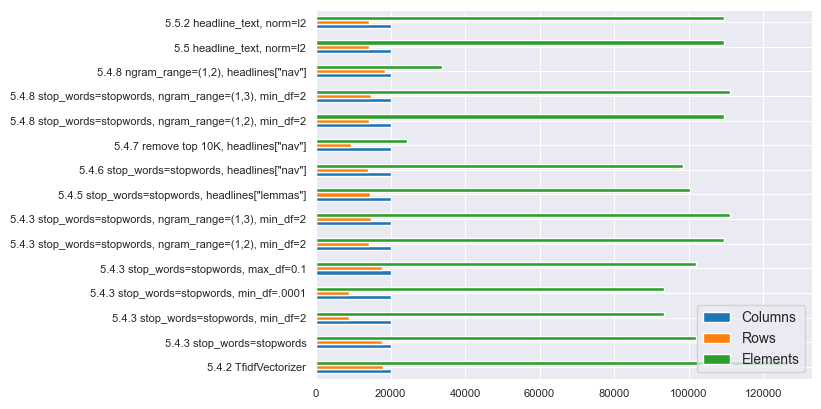

In [82]:
show(matrix_data)

### Timing Cosine Similarity

In [83]:
%%time
cosine_similarity(dt[0:10000], dt[0:10000], dense_output=False)

CPU times: user 27.9 ms, sys: 10.5 ms, total: 38.4 ms
Wall time: 36.8 ms


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1277455 stored elements and shape (10000, 10000)>

In [84]:
%%time
r = cosine_similarity(dt[0:10000], dt[0:10000])
r[r > 0.9999] = 0
print(np.argmax(r))

57679793
CPU times: user 483 ms, sys: 337 ms, total: 820 ms
Wall time: 908 ms


In [85]:
%%time
r = cosine_similarity(dt[0:10000], dt[0:10000], dense_output=False)
r[r > 0.9999] = 0
print(np.argmax(r))

57679793
CPU times: user 517 ms, sys: 140 ms, total: 657 ms
Wall time: 676 ms


### Timing Dot-Product

In [86]:
%%time
r = np.dot(dt[0:10000], np.transpose(dt[0:10000]))
r[r > 0.9999] = 0
print(np.argmax(r))

57679793
CPU times: user 490 ms, sys: 41.2 ms, total: 531 ms
Wall time: 535 ms


### Batch

In [87]:
%%time
batch = 10_000
max_sim = 0.0
max_a = None
max_b = None

for a in range(0, dt.shape[0], batch):
    for b in range(0, a+batch, batch):
        print(a, b)
        #r = np.dot(dt[a:a+batch], np.transpose(dt[b:b+batch]))
        r = cosine_similarity(dt[a:a+batch], dt[b:b+batch], dense_output=False)
        
        # Eliminate identical vectors by setting similarity to np.nan which gets sorted out
        r[r > 0.9999] = 0
        sim = r.max()
        if sim > max_sim:
            # argmax returns a single value which we have to map to the two dimensions            
            (max_a, max_b) = np.unravel_index(np.argmax(r), r.shape)
            # Adjust offsets in corpus (this is a submatrix)
            max_a += a
            max_b += b
            max_sim = sim

0 0
10000 0
10000 10000
CPU times: user 1.1 s, sys: 99 ms, total: 1.2 s
Wall time: 1.23 s


In [88]:
print(max_a, max_b)

10595 7846


In [89]:
print(headlines.iloc[max_a])
HR()
print(headlines.iloc[max_b])

publish_date                       2009-11-28 00:00:00
headline_text    skydiver killed after parachute fails
lemmas              skydiver kill after parachute fail
nav                       skydiver kill parachute fail
Name: 503815, dtype: object
----------------------------------------
publish_date                               2013-02-08 00:00:00
headline_text    skydiver killed after parachute fails to open
lemmas              skydiver kill after parachute fail to open
nav                          skydiver kill parachute fail open
Name: 761719, dtype: object


In [90]:
print(max_sim)

0.9681980958066154


In [93]:
try:
    pd.set_option('max_colwidth', -1)
    headlines.iloc[[max_a, max_b]][["publish_date", "headline_text"]]
except Exception as e:
    print(e)

Value must be a nonnegative integer or None


<a name='5.5.3'></a><a id='5.5.3'></a>
## 5.5.3 Blueprint: Finding Related Words
<a href="#top">[back to top]</a>

Instead of just word-similarity, we want to obtain information about related words. We define words as "related" if they frequently appear together in documents. 

Here, instead of working with a document-term matrix, we switch to a *term-document matrix*, which is just its transposed form. Instead of taking row vectors, we now take column vectors. However, we need to re-vectorize the data. 

In [94]:
tfidf_word = TfidfVectorizer(
    stop_words=stopwords, 
    min_df=50 # 1000
)

dt_word = tfidf_word.fit_transform(
    headlines["headline_text"]
)

examine_matrix(dt_word, '5.5.3 min_df=50')

Columns        20,000
Rows              322
Elements       30,645
Bytes         245,160
Gigabytes     0.00023


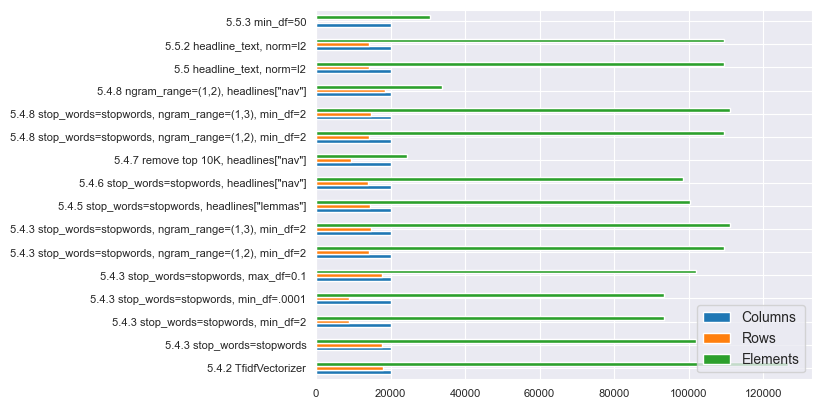

In [95]:
show(matrix_data)

Because the vocabulary is small, we can directly calculate the cosine similarity. We change the row for column vectors, and transpose the matrix.

In [96]:
r = cosine_similarity(dt_word.T, dt_word.T)
np.fill_diagonal(r, 0)

Finding the largest entries is easiest if we convert it to a one-dimensional array, get the index of the sorted elements via np.argsort, and restore the original indices for the vocabulary lookup.

In [97]:
voc = tfidf_word.get_feature_names_out()

size = r.shape[0] # quadratic
for index in np.argsort(r.flatten())[::-1][0:40]:
    a = int(index/size)
    b = index%size
    spacer = ""
    if a > b:  # avoid repetitions
        print(f'{voc[a]:<9} related to {spacer:<2} {voc[b]}')

hour      related to    country
climate   related to    change
gold      related to    coast
search    related to    missing
share     related to    market
north     related to    korea
world     related to    cup
rise      related to    rate
fatal     related to    crash
news      related to    national
guilty    related to    found
south     related to    east
job       related to    cuts
news      related to    abc
vic       related to    hour
found     related to    body
search    related to    continues
child     related to    abuse
rural     related to    national
rural     related to    news


<a name='5.5.4'></a><a id='5.5.4'></a>
## 5.5.4 Tips for Long-Running Programs like Syntactic Similarity
<a href="#top">[back to top]</a>

No source code.